In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sbn
import pandas as pd
from matplotlib.pyplot import figure
from itertools import cycle, islice
from power_perp import everlasting_power_perp_price, everlasting_power_perp_price_,  power_perp_price


In [2]:
def liteGBM(S0, mu, sigma, T, dt=1):
    N = round(T/dt)
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size = N) 
    W = np.cumsum(W)*np.sqrt(dt)
    S =  S0*np.exp((mu-0.5*sigma**2)*t + sigma*W)
    return np.insert(S,0,S0)

<AxesSubplot:>

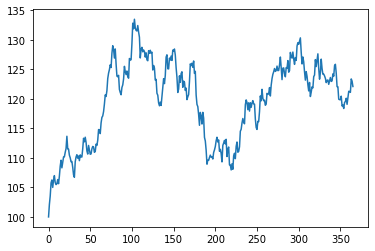

In [3]:
# One sim
S = liteGBM(S0 = 100, mu = 0, sigma = 0.2, T =1, dt = 1/365)
sbn.lineplot(data=S)

In [89]:
# Set up params
spot = 100
vol = 0.8
drift = 0
fundingPeriod = 30/365
numPeriodsPerFunding = 100
T = fundingPeriod
power = 2

In [90]:
# Power perp pricing
power_perp_price(spot, fundingPeriod, vol, drift, power)

10540.108453014238

In [92]:
# Simulator for total pnl
def simPerp(S0, mu, sigma, numPeriodsPerFunding, fundingPeriod, T, Minf): # Minf is the pricing function
    # GBM path
    dt = fundingPeriod/numPeriodsPerFunding
    S = liteGBM(S0=S0, mu = mu, sigma=sigma, T = T, dt = dt)
    # Funding path (Mark - Index)
    #d = [( Minf(s) + s**2)/2 - s**2  for s in S[1:]] # Dave's proposed variation (Average of mark and index - index)
    d = [ (Minf(s) - s**2)/numPeriodsPerFunding for s in S[1:]]
    # Total cash for long power perp (cost - funding + sale) 
    return -Minf(S0) - np.sum(d) + Minf(S[-1])

<AxesSubplot:>

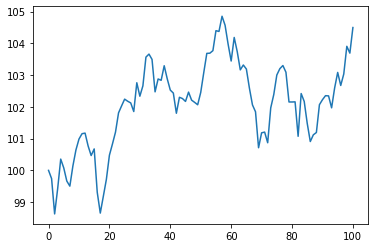

In [122]:
# one full funding period realization
dt = fundingPeriod/numPeriodsPerFunding
S = liteGBM(S0=spot, mu = drift, sigma=0.2, T = fundingPeriod, dt = dt)
sbn.lineplot(data=S)

In [123]:
power_perp_price(spot, fundingPeriod, vol, drift, power)

10540.108453014238

In [136]:
# Simulate funding along paths using expiring price at the funding period
Minf = lambda spot: power_perp_price(spot, fundingPeriod, vol, drift, power)
tmp =[simPerp(100, 0, 0.8, numPeriodsPerFunding, fundingPeriod=fundingPeriod, T=T, Minf=Minf) for _ in range(10000)]
np.mean(tmp)

139.12584671983524

Some more checks:
- Mark and index seem reasonable 
- Funding % and $ are as expected
- GBM is behaving properly 

<AxesSubplot:>

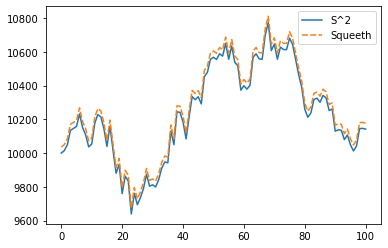

In [80]:
# Look at price vs squeeth
Minf = lambda spot: everlasting_power_perp_price(spot, fundingPeriod, vol, drift, power)
sbn.lineplot(data={'S^2':S**2, 'Squeeth':Minf(S)})

<AxesSubplot:>

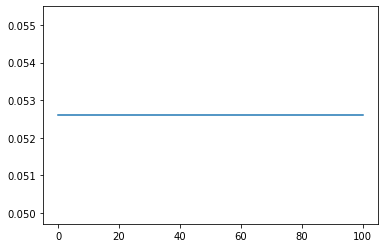

In [137]:
# Funding as %
sbn.lineplot(data=np.log(Minf(S)/S**2))

<AxesSubplot:>

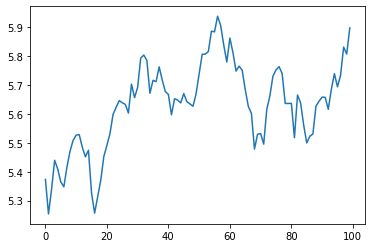

In [143]:
# Fundign in dollars
d = [(Minf(s)-s**2)/numPeriodsPerFunding for s in S[1:]]
sbn.lineplot(data=d)

In [144]:
-Minf(S[0]) 

-10540.108453014238

In [145]:
- np.sum(d)  

-562.9948836309649

In [146]:
Minf(S[-1])

11509.077840357233

In [147]:
# Check returns for GBM
np.mean([liteGBM(S0 = 100, mu = 0, sigma = 0.2, T =1, dt = 1/365)[-1] for _ in range(10000)])

99.87588241390738

In [148]:
# Check vol for GBM
np.mean([np.std(np.diff(np.log(liteGBM(S0 = 100, mu = 0, sigma = 0.2, T =1, dt = 1/365))))*np.sqrt(365) for _ in range(10000)])

0.19963769859812047

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>]

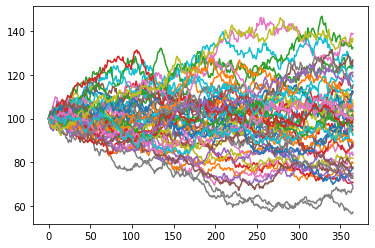

In [150]:
[sbn.lineplot(data=liteGBM(S0 = 100, mu = 0, sigma = 0.2, T =1, dt = 1/365)) for _ in range(50)]

In [ ]:
def everlasting_power_perp_price(spot, funding_period, vol, drift, power, time_to_tick=0):
    """
    `time_to_tick` determines the first term in the geometric series.
    The formula located at https://www.paradigm.xyz/2021/08/power-perpetuals/
    assumes that `time_to_tick = funding_period`.
    """
    k = (power - 1) * (2 * drift + power * vol ** 2) / 2
    return (spot ** power) * np.exp(time_to_tick * k) / (2 - np.exp(funding_period * k))